# Exploratory Data Analysis (EDA)

In [3]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import HeatMap

In [4]:
# Create mappings between differently formatted city names
city_name_mapping = {
    'New York-Newark-Jersey City': ['New York city, New York', 'Newark city, New Jersey', 'Jersey City city, New Jersey'],
    'Los Angeles-Long Beach-Anaheim': ['Los Angeles city, California', 'Long Beach city, California', 'Anaheim city, California'],
    'Chicago-Naperville-Elgin': ['Chicago city, Illinois', 'Naperville city, Illinois', 'Elgin city, Illinois'],
    'Dallas-Fort Worth-Arlington': ['Dallas city, Texas', 'Fort Worth city, Texas', 'Arlington city, Texas'],
    'Houston-The Woodlands-Sugar Land': ['Houston city, Texas', 'The Woodlands CDP, Texas', 'Sugar Land city, Texas'],
    'Washington-Arlington-Alexandria': ['Washington city, District of Columbia', 'Arlington CDP, Virginia', 'Alexandria city, Virginia'],
    'Miami-Fort Lauderdale-West Palm Beach': ['Miami city, Florida', 'Fort Lauderdale city, Florida', 'West Palm Beach city, Florida'],
    'Philadelphia-Camden-Wilmington': ['Philadelphia city, Pennsylvania', 'Camden city, New Jersey', 'Wilmington city, Delaware'],
    'Atlanta-Sandy Springs-Roswell': ['Atlanta city, Georgia', 'Sandy Springs city, Georgia'],
    'Boston-Cambridge-Newton': ['Boston city, Massachusetts', 'Cambridge city, Massachusetts']
}

# Flatten the mapping for filtering
target_cities = [city for cities in city_name_mapping.values() for city in cities]

In [5]:
# Load datasets
affordability_files = [
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2006-2010.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2007-2011.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2008-2012.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2009-2013.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2010-2014.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2011-2015.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2012-2016.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2013-2017.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2014-2018.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2015-2019.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2016-2020.csv',
    '../data/clean_data/affordability_metrics/cost_burden/affordability_2017-2021.csv'
]
metro_housing_prices_path = '../data/clean_data/affordability_metrics/housing_costs/metro_housing_prices.csv'
metro_rental_prices_path = '../data/clean_data/affordability_metrics/housing_costs/metro_rental_prices.csv'
metro_rental_prices_path = '..data/clean_data/affordability_metrics/housing_costs/metro_rental_prices.csv'

## Trend of Housing Cost Burden Over Time by Metro Area

Insight Goal: Visualize the changes in housing cost burden over time for the ten metro areas, helping to identify areas that are becoming more financially strained.

Loaded data from ../data/clean_data/affordability_metrics/cost_burden/affordability_2006-2010.csv, sample:
                               city  year       A1        A2        A3  \
0          New York city, New York  2010  83720.0  593130.0  676850.0   
1          Camden city, New Jersey  2010   1960.0    7455.0    9415.0   
2     Jersey City city, New Jersey  2010   1445.0   15700.0   17145.0   
3          Newark city, New Jersey  2010   2715.0   26660.0   29375.0   
4  Philadelphia city, Pennsylvania  2010  59145.0  100900.0  160045.0   

        A4        A5        A6        A7        A8  ...       J2       J4  \
0  93570.0  318565.0  412135.0  150230.0  361385.0  ...  59335.0  69405.0   
1   2115.0    3030.0    5145.0    2390.0    1945.0  ...   1305.0   1185.0   
2   2060.0    8590.0   10650.0    3855.0   10265.0  ...   1235.0   1830.0   
3   2875.0   13935.0   16810.0    3990.0   10715.0  ...   2235.0   2515.0   
4  44255.0   43115.0   87370.0   61930.0   47730.0  ...  29985.0  21

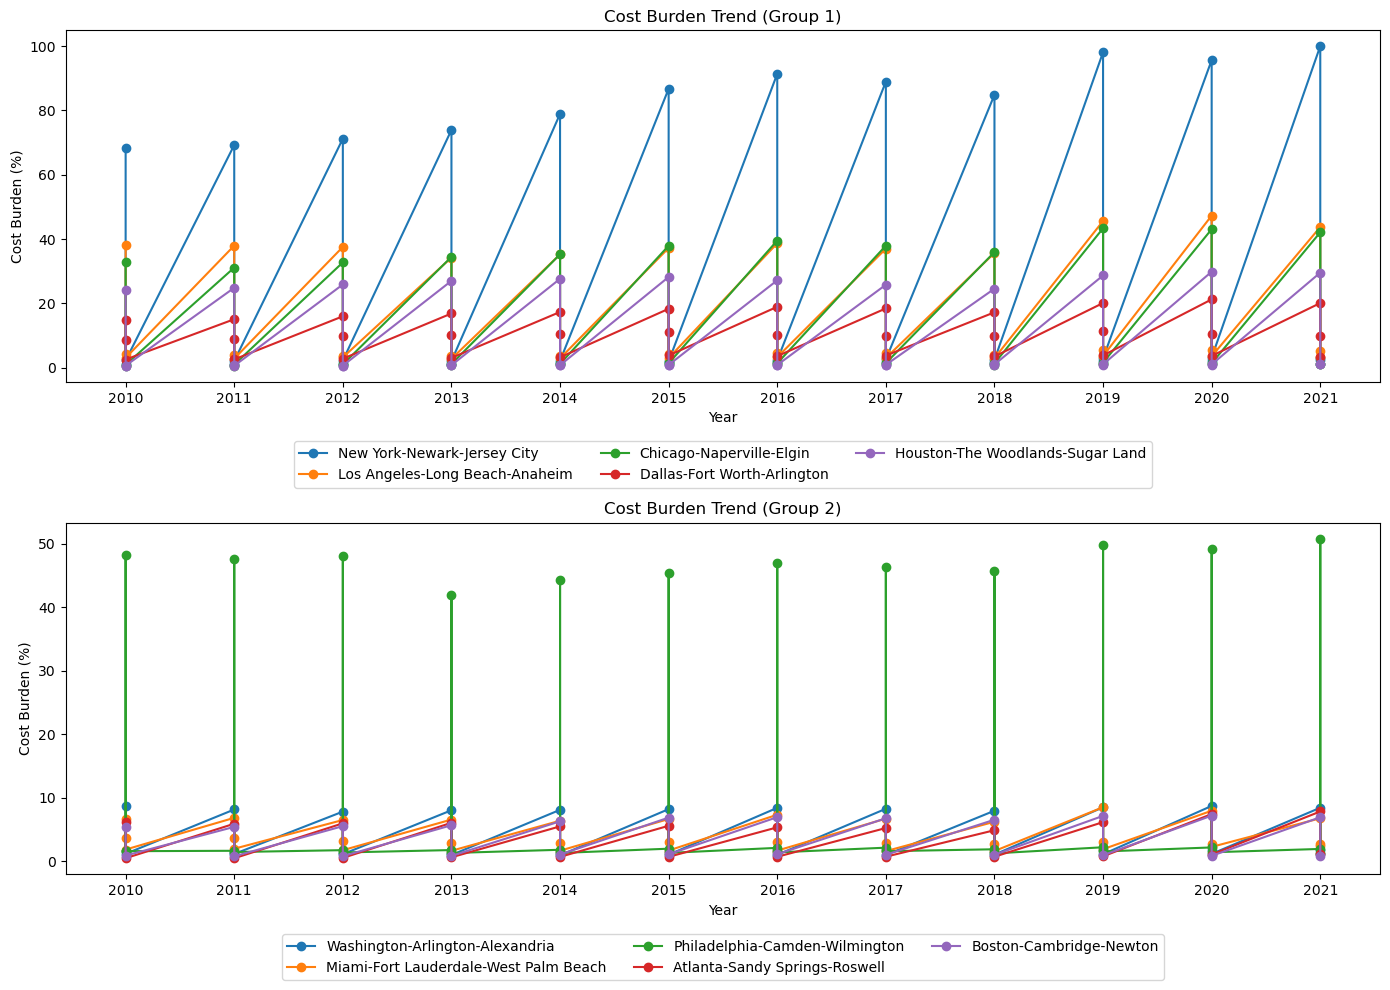

In [7]:
# Insight 1: Trend of Housing Cost Burden Over Time by Metro Area
cost_burden_dfs = []
for file in affordability_files:
    # Extract the year from the filename
    year = int(re.search(r'affordability_(\d{4})-(\d{4})\.csv', file).group(2))
    df = pd.read_csv(file)
    df['year'] = year  # Assign the extracted year to the dataframe
    print(f"Loaded data from {file}, sample:\n", df.head())  # Diagnostic print statement
    cost_burden_dfs.append(df)

cost_burden_data = pd.concat(cost_burden_dfs)
print("Concatenated cost burden data sample:\n", cost_burden_data.head())  # Diagnostic print statement

# Filter the dataset using the mapped city names
cost_burden_data = cost_burden_data[cost_burden_data['city'].isin(target_cities)]
print("Filtered cost burden data sample (after filtering for target cities):\n", cost_burden_data.head())  # Diagnostic print statement

# Drop rows with NaN values in 'A1'
cost_burden_data = cost_burden_data.dropna(subset=['A1'])
print("Processed cost burden data sample (after NaN removal):\n", cost_burden_data.head())  # Diagnostic print statement

# Normalize 'A1' to represent percentages (assuming 'A1' is in counts)
max_value = cost_burden_data['A1'].max()
cost_burden_data['A1'] = (cost_burden_data['A1'] / max_value) * 100
print("Processed cost burden data sample (after normalization to percentage):\n", cost_burden_data.head())  # Diagnostic print statement

# Check if there is any data left to plot after filtering
if cost_burden_data.empty:
    print("Warning: The cost burden data is empty after filtering and processing. Please check the filtering criteria.")
else:
    print("Data is available for plotting.")

# Plotting cost burden trends split into two groups of 5 metro areas
group_1_metro_areas = list(city_name_mapping.keys())[:5]
group_2_metro_areas = list(city_name_mapping.keys())[5:]

plt.figure(figsize=(14, 10))

# Group 1
plt.subplot(2, 1, 1)
for metro in group_1_metro_areas:
    metro_data = cost_burden_data[cost_burden_data['city'].isin(city_name_mapping[metro])]
    if not metro_data.empty:
        print(f"Plotting data for metro: {metro}, sample:\n", metro_data.head())  # Diagnostic print statement
        plt.plot(metro_data['year'], metro_data['A1'], marker='o', linestyle='-', label=metro)
    else:
        print(f"No data available for metro: {metro}")
plt.xlabel('Year')
plt.ylabel('Cost Burden (%)')
plt.title('Cost Burden Trend (Group 1)')
plt.xticks(sorted(cost_burden_data['year'].unique()))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Group 2
plt.subplot(2, 1, 2)
for metro in group_2_metro_areas:
    metro_data = cost_burden_data[cost_burden_data['city'].isin(city_name_mapping[metro])]
    if not metro_data.empty:
        print(f"Plotting data for metro: {metro}, sample:\n", metro_data.head())  # Diagnostic print statement
        plt.plot(metro_data['year'], metro_data['A1'], marker='o', linestyle='-', label=metro)
    else:
        print(f"No data available for metro: {metro}")
plt.xlabel('Year')
plt.ylabel('Cost Burden (%)')
plt.title('Cost Burden Trend (Group 2)')
plt.xticks(sorted(cost_burden_data['year'].unique()))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.savefig("../plots/housing_cost_burden_time.png")
plt.show()

**Interpretation**

1. Y-Axis (Cost Burden %):

Indicates the percentage of households experiencing a housing cost burden (typically defined as spending more than 30% of income on housing).

2. X-Axis (Years):

Represents the timeline from 2010 to 2021, showing how the cost burden percentage has changed annually.

3. Metro Area Trends:

The lines show each metro area's trajectory over time.

**Insights**

1. Steady Trends vs. Spikes:

    - Some metro areas, like New York-Newark-Jersey City, show consistently higher cost burdens across the years, suggesting persistent affordability issues.
    - In Group 2, areas like Philadelphia-Camden-Wilmington seem to have large fluctuations, which might indicate external factors like economic policies or housing crises influencing affordability.

2. Comparison Across Groups

    - Metro areas in Group 1 generally show less variability and may have consistently high or low cost burdens.
    - Group 2 displays a more diverse range of trends, with some cities maintaining stable cost burdens while others show spikes.

3. Outliers

    - Philadelphia-Camden-Wilmington in Group 2 shows a significantly high cost burden in certain years. This anomaly warrants further investigation.

## Distribution of Housing Cost Burden by Metro Area

Insight Goal: Explore the distribution of housing cost burden across the ten metro areas to pinpoint which regions are most affected.

In [9]:
# Insight 2: Distribution of Housing Cost Burden by Metro Area
cost_burden_latest = cost_burden_data[cost_burden_data['year'] == cost_burden_data['year'].max()]
print("Latest cost burden data sample (for choropleth map):\n", cost_burden_latest.head())  # Diagnostic print statement

# Check if there is any data left to plot after selecting the latest year
if cost_burden_latest.empty:
    print("Warning: The cost burden data for the latest year is empty. Please check the filtering criteria.")
else:
    # Create a base map
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

    # Metro area coordinates (simplified, representative coordinates for each metro area)
    metro_coordinates = {
        'New York-Newark-Jersey City': [40.7128, -74.0060],
        'Los Angeles-Long Beach-Anaheim': [34.0522, -118.2437],
        'Chicago-Naperville-Elgin': [41.8781, -87.6298],
        'Dallas-Fort Worth-Arlington': [32.7767, -96.7970],
        'Houston-The Woodlands-Sugar Land': [29.7604, -95.3698],
        'Washington-Arlington-Alexandria': [38.9072, -77.0369],
        'Miami-Fort Lauderdale-West Palm Beach': [25.7617, -80.1918],
        'Philadelphia-Camden-Wilmington': [39.9526, -75.1652],
        'Atlanta-Sandy Springs-Roswell': [33.7490, -84.3880],
        'Boston-Cambridge-Newton': [42.3601, -71.0589]
    }

    # Adjust filtering logic to handle city name variations
    for metro, coord in metro_coordinates.items():
        matching_cities = city_name_mapping[metro]
        filtered_data = cost_burden_latest[cost_burden_latest['city'].isin(matching_cities)]
        if not filtered_data.empty:
            cost_burden = filtered_data['A1'].values[0]
            print(f"Adding marker for metro: {metro}, Cost Burden: {cost_burden}")  # Diagnostic print statement
            folium.Circle(
                location=coord,
                radius=cost_burden * 1000,  # Scale radius for visibility
                color='blue',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6,
                popup=f"{metro}: {cost_burden:.2f}% Cost Burden"
            ).add_to(m)
        else:
            print(f"No data available for metro: {metro}")

    # Display the map
    m.save('../plots/housing_cost_burden_map.html')
    print("Choropleth map saved as 'housing_cost_burden_map.html'.")

Latest cost burden data sample (for choropleth map):
                               city  year          A1        A2        A3  \
0          New York city, New York  2021  100.000000  680265.0  802865.0   
1          Camden city, New Jersey  2021    1.920881    8030.0   10385.0   
2     Jersey City city, New Jersey  2021    2.230832   19800.0   22535.0   
3          Newark city, New Jersey  2021    3.115824   35385.0   39205.0   
4  Philadelphia city, Pennsylvania  2021   50.815661  104930.0  167230.0   

         A4        A5        A6        A7        A8  ...       J2       J4  \
0  111995.0  329455.0  441450.0  170485.0  373200.0  ...  81250.0  75735.0   
1    1715.0    3370.0    5085.0    2130.0    2115.0  ...   1450.0   1045.0   
2    2995.0   10665.0   13660.0    4495.0   11750.0  ...   2235.0   2380.0   
3    3470.0   16675.0   20145.0    5245.0   16250.0  ...   2895.0   2675.0   
4   47075.0   51980.0   99055.0   58140.0   54040.0  ...  31100.0  20935.0   

        J5       J7 

**Insights from the Choropleth Map**

1. High Cost Burden Areas:
    - New York-Newark-Jersey City stands out with the highest cost burden at 100%, represented by the largest radius on the map. This indicates that this region has a severe housing cost burden, where a significant proportion of residents are spending a substantial amount of their income on housing.

2. Moderate Cost Burden Areas:
    - Metro areas like Los Angeles-Long Beach-Anaheim (43.73%), Chicago-Naperville-Elgin (42.08%), and Philadelphia-Camden-Wilmington (50.82%) also show substantial housing cost burdens, but at a lower rate compared to New York. This indicates that these regions are also facing significant affordability challenges.

3. Lower Cost Burden Areas:
    - Other metro areas such as Miami-Fort Lauderdale-West Palm Beach (6.75%) and Washington-Arlington-Alexandria (8.41%) have relatively low housing cost burdens. This implies that, compared to the other regions, residents in these areas spend a lower percentage of their income on housing.

4. Geographic Distribution:
    - The map provides an intuitive view of the geographic spread of housing cost burdens. It helps in visually identifying which regions are more heavily affected, making it easier to compare across metro areas.
    - The size of the circle and the color gradient on the map indicate the severity of the cost burden across different regions, enabling a quick assessment of areas most in need of intervention.

**Interpretation**

- The map highlights disparities in housing affordability across different metro areas. For policymakers, this can be a critical tool in identifying areas where targeted measures (like affordable housing programs or subsidies) might be required.
- The regions with the highest cost burdens are at a greater risk of facing housing shortages, as affordability issues could deter new residents or make it difficult for current residents to maintain their housing.
- The visual representation aids in understanding the relative severity of cost burdens geographically, which can help stakeholders prioritize resources based on the regions most affected.